### GPU Available?

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17542131240924622214
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14512029696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4263610430487883627
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [2]:
# Import packages
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
!pip install yfinance
import yfinance as yf
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
# Set some display options for Pandas.
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
# Define the symbols
# At different points, we will need to generate metrics based on the number
# of symbols we have, so let's save some time and just calculate that now.
# Read and print the stock tickers 


# Get the data for this tickers from yahoo finance

tickers=["XOM","BAC","IBM","PFE","TSLA"]
number_of_symbols = len(tickers)
Stocks_hist=yf.download(tickers,interval='1d',start='2015-01-01',end='2020-12-31', auto_adjust=True, group_by='ticker',index=False)
Stocks_hist = Stocks_hist.stack(level=0).rename_axis(['Date', 'Index']).reset_index(level=1)
Stocks_hist.to_csv('StockPrices.csv')
price_data_frame = pd.read_csv('StockPrices.csv')#,delimiter=',')
print('Loaded data from the Stocks repository')

# Print the head.
print(price_data_frame.head())


[*********************100%***********************]  5 of 5 completed
Loaded data from the Stocks repository
         Date Index       Close        High         Low        Open    Volume
0  2015-01-02  BAC   15.880880   15.996217   15.685697   15.960728   48951100
1  2015-01-02  IBM   121.796097  122.735534  120.999456  121.232435  5525500 
2  2015-01-02  PFE   23.154585   23.487159   23.073289   23.110243   16371571
3  2015-01-02  TSLA  43.862000   44.650002   42.652000   44.574001   23822000
4  2015-01-02  XOM   67.654991   67.815329   66.911607   67.232283   10220400


### Data Pulling

In [4]:
price_data_frame['Date']= pd.to_datetime(price_data_frame['Date'])
# price_data_frame["DailyRet"] = 0
# price_data_frame["20DayRet"] = 0
# price_data_frame["20DayVol"] = 0
# price_data_frame["Z20DayRet"] = 0
# price_data_frame['Z20DayVol'] = 0
# price_data_frame['Close_log']= 0
# price_data_frame['Close_log_diff']= 0
# price_data_frame['Close_log'] = np.log(price_data_frame['Close'])
# price_data_frame['Close_log_diff'] = price_data_frame['Close_log'] - price_data_frame['Close_log'].shift(1)
# price_data_frame['Close_log_diff'] = price_data_frame['Close_log_diff'].fillna(0,inplace=True)
#df_close = price_data_frame[['Date', 'Index', 'Close_log_diff']]
df_close = price_data_frame[['Date', 'Index', 'Close']]
df_close.head(5)

,Date,Index,Close
0,2015-01-02,BAC,15.880880
1,2015-01-02,IBM,121.796097
2,2015-01-02,PFE,23.154585
3,2015-01-02,TSLA,43.862000
4,2015-01-02,XOM,67.654991


In [5]:
df_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7550 entries, 0 to 7549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7550 non-null   datetime64[ns]
 1   Index   7550 non-null   object        
 2   Close   7550 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 177.1+ KB


In [6]:
#df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values = 'Close_log_diff').dropna(axis=1)
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values = 'Close').dropna(axis=1)
stocks_tickers = df_close.columns
print(stocks_tickers)

Index(['BAC', 'IBM', 'PFE', 'TSLA', 'XOM'], dtype='object', name='Index')


In [7]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.columns
df_close.shape


(1510, 5)

# Feature Engineering

In [8]:
raw_df=yf.download(tickers,interval='1d',start='2015-01-01',end='2020-12-31', auto_adjust=True, group_by='ticker',index=False)
raw_df.head(5)
raw_df = raw_df.dropna(axis = 1)
raw_df.tail(5)

[*********************100%***********************]  5 of 5 completed


BAC                                                   PFE                                                   TSLA                                                       IBM                                                     XOM                                           
                 Open       High        Low      Close    Volume       Open       High        Low      Close    Volume        Open        High         Low       Close    Volume        Open        High         Low       Close   Volume       Open       High        Low      Close    Volume
Date                                                                                                                                                                                                                                                                                           
2020-12-23  29.122153  30.073405  29.062701  29.776138  52537200  35.929063  36.550374  35.802862  36.346504  36182000  632.200012  651.500000  622.570007  645.979980  33173000  119.519640  120.802828  119.384569  119.538940  2693900  39.630914  40.471079  39.583178  39.879147  19085900
2020-12-24  29.994134  29.994134  29.468964  29.686958  22632300  36.307677  36.472710  36.094101  36.181473  14790100  642.989990  666.090027  641.000000  661.770020  22865600  120.600218  120.696697  119.838024  120.301132  1761100  39.764578  39.955522  39.506800  39.716839  8039000 
2020-12-28  29.954499  30.271582  29.716686  29.855410  32861200  36.268843  36.482419  35.608703  35.744614  26993700  674.510010  681.400024  660.799988  663.690002  32278600  120.696703  122.143905  120.079230  120.426559  3615200  39.802766  40.623836  39.640464  39.850506  23877500
2020-12-29  29.895045  29.974316  29.657233  29.736504  33291900  35.822279  36.113516  35.715491  35.967896  23152100  661.000000  669.900024  655.000000  665.989990  22910800  120.937905  121.063334  118.902173  119.442467  3487000  40.136927  40.213304  39.334952  39.401783  20287700
2020-12-30  29.726594  29.944588  29.667141  29.706776  26370100  35.948477  36.152347  35.628118  35.666950  24889800  672.000000  696.599976  668.359985  694.780029  42846000  119.442469  120.455506  119.278447  119.963455  3380300  39.459064  40.499719  39.401779  39.716839  23807300

In [9]:
# for stock in stocks_tickers:
#   #Calculate Daily Returns
#   raw_df.loc[:, (stock, 'DailyRet')] = raw_df[stock]["Close"].pct_change()
#   #Calculate 20-Day Returns
#   raw_df.loc[:, (stock, '20DayRet')] = raw_df[stock]["Close"].pct_change(20)
#   #Calculate Rolling 20 day volatility 
#   roller = raw_df[stock]["DailyRet"].rolling(20)
#   raw_df.loc[:, (stock, '20DayVol')] = roller.std(ddof=0)
  
#   '''Normalize data with the rolling 252'''
#   #Normalize 20 Day Returns 
#   rolling_year_ret = raw_df[stock]["20DayRet"].rolling(252)
#   raw_df.loc[:, (stock, 'Z20DayRet')] = (rolling_year_ret.mean().shift(1) - raw_df[stock]['20DayRet']) / rolling_year_ret.std(ddof=0).shift(1)
#   #Normalize 20 Day Volatility
#   rolling_year_vol = raw_df[stock]["20DayVol"].rolling(252)
#   raw_df.loc[:, (stock, 'Z20DayVol')] = (rolling_year_vol.mean().shift(1) - raw_df[stock]['20DayVol']) / rolling_year_vol.std(ddof=0).shift(1) 


#   raw_df.loc[:, (stock, 'Close_log')] = np.log(raw_df[stock]['Close'])
#   raw_df.loc[:, (stock, 'Close_log_diff')] = raw_df.loc[:, (stock, 'Close_log')] - raw_df.loc[:, (stock, 'Close_log')].shift(1)
#   raw_df.loc[:, (stock, 'Close_log_diff')] = raw_df.loc[:, (stock, 'Close_log_diff')].fillna(0)

In [10]:
raw_df.head(5)

BAC                                                    PFE                                                  TSLA                                                    IBM                                                     XOM                                           
                 Open       High        Low      Close     Volume       Open       High        Low      Close    Volume       Open       High        Low      Close    Volume        Open        High         Low       Close   Volume       Open       High        Low      Close    Volume
Date                                                                                                                                                                                                                                                                                        
2015-01-02  15.960728  15.996217  15.685697  15.880880  48951100   23.110243  23.487159  23.073289  23.154585  16371571  44.574001  44.650002  42.652000  43.862000  23822000  121.232435  122.735534  120.999456  121.796097  5525500  67.232283  67.815329  66.911607  67.654991  10220400
2015-01-05  15.783284  15.801027  15.339684  15.419531  105605500  23.169373  23.213716  22.918093  23.028952  24786391  42.910000  43.299999  41.431999  42.018002  26842500  121.202365  121.202365  119.639141  119.879631  4880400  67.122953  67.341597  65.228061  65.803818  18502400
2015-01-06  15.455021  15.472766  14.887214  14.958190  144912400  23.110247  23.546288  22.999389  23.221106  29468681  42.012001  42.840000  40.841999  42.256001  31309500  119.999867  120.217822  116.617895  117.294296  6146700  65.767381  66.620088  64.878238  65.453995  16670700
2015-01-07  15.206608  15.242097  14.967065  15.029169  104603800  23.442824  23.553682  23.339356  23.538900  20248816  42.669998  42.956001  41.956001  42.189999  14842000  118.143559  118.143559  115.761149  116.527733  4701800  66.066209  66.671119  65.592485  66.117226  13590700
2015-01-08  15.224351  15.384048  15.171120  15.339688  73388500   23.901035  24.122753  23.812349  24.019285  49169522  42.562000  42.759998  42.001999  42.124001  17212500  117.422061  119.526389  116.903490  119.060432  4236800  66.503466  67.246844  66.321264  67.217697  15487500

In [11]:
raw_df.tail(5)

BAC                                                   PFE                                                   TSLA                                                       IBM                                                     XOM                                           
                 Open       High        Low      Close    Volume       Open       High        Low      Close    Volume        Open        High         Low       Close    Volume        Open        High         Low       Close   Volume       Open       High        Low      Close    Volume
Date                                                                                                                                                                                                                                                                                           
2020-12-23  29.122153  30.073405  29.062701  29.776138  52537200  35.929063  36.550374  35.802862  36.346504  36182000  632.200012  651.500000  622.570007  645.979980  33173000  119.519640  120.802828  119.384569  119.538940  2693900  39.630914  40.471079  39.583178  39.879147  19085900
2020-12-24  29.994134  29.994134  29.468964  29.686958  22632300  36.307677  36.472710  36.094101  36.181473  14790100  642.989990  666.090027  641.000000  661.770020  22865600  120.600218  120.696697  119.838024  120.301132  1761100  39.764578  39.955522  39.506800  39.716839  8039000 
2020-12-28  29.954499  30.271582  29.716686  29.855410  32861200  36.268843  36.482419  35.608703  35.744614  26993700  674.510010  681.400024  660.799988  663.690002  32278600  120.696703  122.143905  120.079230  120.426559  3615200  39.802766  40.623836  39.640464  39.850506  23877500
2020-12-29  29.895045  29.974316  29.657233  29.736504  33291900  35.822279  36.113516  35.715491  35.967896  23152100  661.000000  669.900024  655.000000  665.989990  22910800  120.937905  121.063334  118.902173  119.442467  3487000  40.136927  40.213304  39.334952  39.401783  20287700
2020-12-30  29.726594  29.944588  29.667141  29.706776  26370100  35.948477  36.152347  35.628118  35.666950  24889800  672.000000  696.599976  668.359985  694.780029  42846000  119.442469  120.455506  119.278447  119.963455  3380300  39.459064  40.499719  39.401779  39.716839  23807300

In [12]:
raw_df.shape

(1510, 25)

In [13]:
#DROP ROWS WITH NA vals 
full_feature_dataset = raw_df.dropna(axis=0)


# Principal Component Analysis

In [14]:
full_feature_dataset.head()

BAC                                                    PFE                                                  TSLA                                                    IBM                                                     XOM                                           
                 Open       High        Low      Close     Volume       Open       High        Low      Close    Volume       Open       High        Low      Close    Volume        Open        High         Low       Close   Volume       Open       High        Low      Close    Volume
Date                                                                                                                                                                                                                                                                                        
2015-01-02  15.960728  15.996217  15.685697  15.880880  48951100   23.110243  23.487159  23.073289  23.154585  16371571  44.574001  44.650002  42.652000  43.862000  23822000  121.232435  122.735534  120.999456  121.796097  5525500  67.232283  67.815329  66.911607  67.654991  10220400
2015-01-05  15.783284  15.801027  15.339684  15.419531  105605500  23.169373  23.213716  22.918093  23.028952  24786391  42.910000  43.299999  41.431999  42.018002  26842500  121.202365  121.202365  119.639141  119.879631  4880400  67.122953  67.341597  65.228061  65.803818  18502400
2015-01-06  15.455021  15.472766  14.887214  14.958190  144912400  23.110247  23.546288  22.999389  23.221106  29468681  42.012001  42.840000  40.841999  42.256001  31309500  119.999867  120.217822  116.617895  117.294296  6146700  65.767381  66.620088  64.878238  65.453995  16670700
2015-01-07  15.206608  15.242097  14.967065  15.029169  104603800  23.442824  23.553682  23.339356  23.538900  20248816  42.669998  42.956001  41.956001  42.189999  14842000  118.143559  118.143559  115.761149  116.527733  4701800  66.066209  66.671119  65.592485  66.117226  13590700
2015-01-08  15.224351  15.384048  15.171120  15.339688  73388500   23.901035  24.122753  23.812349  24.019285  49169522  42.562000  42.759998  42.001999  42.124001  17212500  117.422061  119.526389  116.903490  119.060432  4236800  66.503466  67.246844  66.321264  67.217697  15487500

In [15]:
full_feature_dataset.tail(5)

BAC                                                   PFE                                                   TSLA                                                       IBM                                                     XOM                                           
                 Open       High        Low      Close    Volume       Open       High        Low      Close    Volume        Open        High         Low       Close    Volume        Open        High         Low       Close   Volume       Open       High        Low      Close    Volume
Date                                                                                                                                                                                                                                                                                           
2020-12-23  29.122153  30.073405  29.062701  29.776138  52537200  35.929063  36.550374  35.802862  36.346504  36182000  632.200012  651.500000  622.570007  645.979980  33173000  119.519640  120.802828  119.384569  119.538940  2693900  39.630914  40.471079  39.583178  39.879147  19085900
2020-12-24  29.994134  29.994134  29.468964  29.686958  22632300  36.307677  36.472710  36.094101  36.181473  14790100  642.989990  666.090027  641.000000  661.770020  22865600  120.600218  120.696697  119.838024  120.301132  1761100  39.764578  39.955522  39.506800  39.716839  8039000 
2020-12-28  29.954499  30.271582  29.716686  29.855410  32861200  36.268843  36.482419  35.608703  35.744614  26993700  674.510010  681.400024  660.799988  663.690002  32278600  120.696703  122.143905  120.079230  120.426559  3615200  39.802766  40.623836  39.640464  39.850506  23877500
2020-12-29  29.895045  29.974316  29.657233  29.736504  33291900  35.822279  36.113516  35.715491  35.967896  23152100  661.000000  669.900024  655.000000  665.989990  22910800  120.937905  121.063334  118.902173  119.442467  3487000  40.136927  40.213304  39.334952  39.401783  20287700
2020-12-30  29.726594  29.944588  29.667141  29.706776  26370100  35.948477  36.152347  35.628118  35.666950  24889800  672.000000  696.599976  668.359985  694.780029  42846000  119.442469  120.455506  119.278447  119.963455  3380300  39.459064  40.499719  39.401779  39.716839  23807300

In [16]:
full_feature_dataset = full_feature_dataset.to_numpy()
full_feature_dataset.shape

(1510, 25)

### Performing PCA to Extract most useful features for the dataset

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# LSTM Stock Prediction

## Data Manipulation

In this section several steps are performed...
- Set our lookback/training window and horizon/testing window
- Create a training, validation, and test set
- Scale the data using MinMaxScaler
- Process data into arrays with ranges of dates from (lookback, t) and (t+1, horizon). T jumps by one day each time.

In [18]:
closing_prices = df_close.iloc[:full_feature_dataset.shape[0],:]

Creating train and test sets

In [19]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(closing_prices, shuffle = False, test_size = .2)
PCA_train, PCA_test = train_test_split(full_feature_dataset, shuffle = False, test_size = .2)

In [20]:
print(array_train.shape)
print(PCA_train.shape)

(1208, 5)
(1208, 25)


In [21]:
from sklearn.decomposition import PCA
pc3 = PCA()
temp = pc3.fit_transform(PCA_train)

###Nearly all data is explained by 5 components

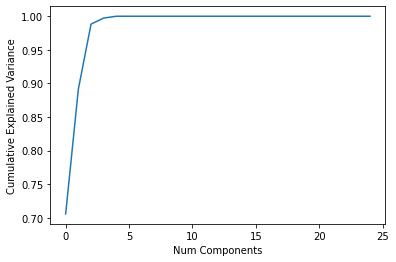

In [22]:
plt.plot(np.cumsum(pc3.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

Scaling the Data

In [23]:
#Data with only closing prices
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scl_array_train = StandardScaler()
scl_array_test = StandardScaler()
array_train = scl_array_train.fit_transform(array_train)
array_test  = scl_array_test.fit_transform(array_test) #[0,1]

#Full features dataset; reducing dimensionality here
from sklearn.decomposition import PCA
Train_scl = StandardScaler()
Test_scl  = StandardScaler()

pcaTrain = PCA(n_components =  len(tickers))
pcaTest = PCA(n_components =  len(tickers))

PCA_train = Train_scl.fit_transform(PCA_train)
PCA_train = pcaTrain.fit_transform(PCA_train)

PCA_test = Test_scl.fit_transform(PCA_test)
PCA_test = pcaTest.fit_transform(PCA_test)

In [24]:
print(array_train.shape)
print(PCA_train.shape)

(1208, 5)
(1208, 5)


Creating function to iteravely process data

In [25]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

Setting lookback and horizon window sizes

In [26]:
num_companies = df_close.shape[1]
lookback = 60 #How many days of the past can the model see
horizon = 22 #How many days into the future are we trying to predict

Further splitting the train data into training and validation sets

In [27]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

#Testing Data
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

#Training/Validation Data
X_PCA, void = processData(PCA_train,lookback,horizon,num_companies)
void, y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.20, random_state=0)

In [28]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(901, 60, 5)
(226, 60, 5)
(11, 60, 5)
(901, 110)
(226, 110)
(11, 110)


## Model Architecture + Training

Here, we can input the number or neurons on each layer, change the level of dropout, and set the specifications for early dropout. The model is then trained and the learning curve is plotted below.

In [29]:
import keras
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.layers import LSTM,Dense,Activation,Attention,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 =800
num_neurons_L2 =600
EPOCHS = 50
optimizer = keras.optimizers.Adam(learning_rate=0.001)
#Model
model = Sequential()
model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies, activation = 'relu'))
#model.add(Dense(horizon * num_companies, activation = 'sigmoid'))
model.compile(loss='mean_squared_error', optimizer= optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 800)           2579200   
_________________________________________________________________
dropout (Dropout)            (None, 60, 800)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 600)               3362400   
_________________________________________________________________
dense (Dense)                (None, 110)               66110     
Total params: 6,007,710
Trainable params: 6,007,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Early stopping severly *underfits* the data, we are going for better results
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

for iter in range(20):
  print("Iternation # : ", iter)
  history = model.fit(X_train,y_train,epochs=EPOCHS,
                      validation_data=(X_validate,y_validate),
                      shuffle=False,batch_size=4,verbose=2)

Iternation # :  0
Epoch 1/50
226/226 - 9s - loss: 0.6514 - accuracy: 0.0366 - val_loss: 0.5316 - val_accuracy: 0.0531
Epoch 2/50
226/226 - 5s - loss: 0.5824 - accuracy: 0.0511 - val_loss: 0.5187 - val_accuracy: 0.0398
Epoch 3/50
226/226 - 5s - loss: 0.5632 - accuracy: 0.0666 - val_loss: 0.5044 - val_accuracy: 0.0442
Epoch 4/50
226/226 - 5s - loss: 0.5466 - accuracy: 0.0566 - val_loss: 0.4759 - val_accuracy: 0.0531
Epoch 5/50
226/226 - 5s - loss: 0.5350 - accuracy: 0.0999 - val_loss: 0.4691 - val_accuracy: 0.0841
Epoch 6/50
226/226 - 5s - loss: 0.5276 - accuracy: 0.0988 - val_loss: 0.4602 - val_accuracy: 0.0929
Epoch 7/50
226/226 - 5s - loss: 0.5199 - accuracy: 0.1032 - val_loss: 0.4531 - val_accuracy: 0.1018
Epoch 8/50
226/226 - 5s - loss: 0.5140 - accuracy: 0.1165 - val_loss: 0.4502 - val_accuracy: 0.1062
Epoch 9/50
226/226 - 5s - loss: 0.5118 - accuracy: 0.1110 - val_loss: 0.4459 - val_accuracy: 0.0973
Epoch 10/50
226/226 - 5s - loss: 0.5095 - accuracy: 0.1421 - val_loss: 0.4466 - va

Plotting the learning curve - Loss

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

### Predicting Test Results

In [ ]:
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])


Xt = model.predict(X_test)
Xt.shape

### Un-scaling the data and returning data to original shape
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [ ]:
#Aux function 1
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl_array_train.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [ ]:
#Aux function 2
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
#Aux function 3
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

In [ ]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

### Prediction Results on Test Data - Plot

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ["XOM","BAC","IBM","PFE","TSLA"]
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
full_PCA = np.concatenate((PCA_train,PCA_test),axis = 0)

In [ ]:
X_all,void = processData(full_PCA,lookback,horizon,num_companies,horizon)
void,y_all = processData(scl_array_train.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

In [ ]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

### Prediction Results on Full Data - Plot

In [ ]:
plt.figure(figsize = (40,10))

companies_to_show = [0] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ["XOM","BAC","IBM","PFE","TSLA"]

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

##QQ-plot

# Stock Prices Predictions

In [ ]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

In [ ]:
actuals_prices = actuals[:,:counter].T

In [ ]:
print(predicted_prices.shape)
print(actuals_prices.shape)
print(dates.shape)
#(lookback+1, )

In [ ]:
dates.shape[0]-lookback-counter

In [ ]:
# Need to remove certain days because we predict into the future. But, we aren't able to test these predicted days
# against actual days in our porfolio optimization

actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:1511-(dates.shape[0]-lookback -counter)])
predicted_prices = pd.DataFrame(data = predicted_prices,columns = stocks,index = dates[lookback+1:1511-(dates.shape[0]-lookback-counter)])

In [ ]:
actual_prices.tail(5)

In [ ]:
predicted_prices.tail(5)

In [ ]:
predicted_prices.to_csv('PCA_Predicted_Prices.csv')

In [ ]:
actual_prices.to_csv('PCA_Actual_Prices.csv')

In [ ]:
#Model : LSTM
PCA_Predicted_Prices = pd.read_csv('PCA_Predicted_Prices.csv')
PCA_Predicted_Prices['Date'] =  pd.to_datetime(PCA_Predicted_Prices['Date'])
PCA_Predicted_Prices=PCA_Predicted_Prices.set_index('Date')

PCA_Actual_Prices = pd.read_csv('PCA_Actual_Prices.csv')
PCA_Actual_Prices['Date'] =  pd.to_datetime(PCA_Actual_Prices['Date'])
PCA_Actual_Prices=PCA_Actual_Prices.set_index('Date')

In [ ]:
#Computing Log Returns
PCA_Predicted_Returns = PCA_Predicted_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 
PCA_Actual_Returns = PCA_Actual_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(PCA_Actual_Prices, PCA_Predicted_Prices)

# Optimize Function Using SciPy


We run the optimization using the `scipy.optimization` module. This module has a function called `minimize` which we can use to help our optimial values. However, we need to do a few things before we run it. 
First, we need to define bounds which tells the `minimize` function that each of our positions can only be between 0% and 100% of the allocation. 
Second, we need to define the constraint which will be a function that ensures the sum of the weights is 100%. In other words, we use all the capital we can.
Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case we start with an equally distirbuted portofolio. We have 5 symbols so each symbol will be 20% of the portfolio.

In [ ]:
# Calculate the Log of returns.
log_return = np.log(1 + predicted_prices.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)

In [ ]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

Once we've define these steps we can run the optimization by passing through the arguments defined and using the method as `SLSQP` which is short for Sequential Least Squares Programming. Then we run the minimize method to grab the results.

In [ ]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)

The first is the results of our minimization operation. Inside the results, there is the optimize sharpe ration defined by the `fun` value. We can then take the `optimized_weights` defined in the `optimized_sharpe.x` values, and use them to return the different metrics we have for our portfolio.

In [ ]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)

In [ ]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)

In [ ]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)